FileNotFoundError: [Errno 2] No such file or directory: 'comm_flow/ex_comm_t1.png'

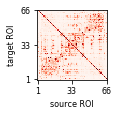

In [3]:
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt
import matplotlib.pyplot as pp
import os

param_dir = './' # where the model estimates (J_mod, Sigma_mod) are located

############
# simulation

# network properties
n_sub = 22
n_run = 5
N = 66 # number of ROIs

ROI_labels = np.array(np.load('ROI_labels.npy'),dtype=np.str)

J = np.load(param_dir+'J_mod.npy')
   
mask_diag = np.eye(N,dtype=np.bool)
mask_offdiag = np.logical_not(mask_diag)


# diagonal of Jacobian
J0 = np.array(J)
J0[:,:,mask_offdiag] = 0


# simulation properties
T = 40. # duration
dt = 1. # time step
vT = np.arange(0,T+dt*0.5,dt) # discrete simulation steps
nT = vT.size

# calculate dynamic communicability
comm = np.zeros([n_sub,n_run,nT,N,N]) # dynamic communicability tensor
for i_sub in range(n_sub):
    for i_run in range(n_run):
        renorm_factor = -np.sum(1./J0[i_sub,i_run,:,:].diagonal()) # integral value of the diagonal Jacobian
        for iT in range(nT):
            comm[i_sub,i_run,iT,:,:] = (spl.expm(J[i_sub,i_run,:,:]*vT[iT]) - spl.expm(J0[i_sub,i_run,:,:]*vT[iT])) / renorm_factor
            

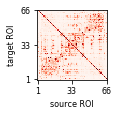

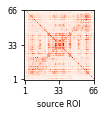

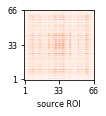

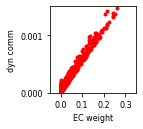

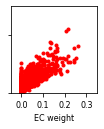

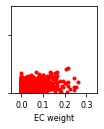

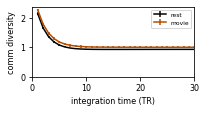

In [6]:


# communicability matrix at 2 times
for iT in [1,4,10]:
    pp.figure(figsize=[1.5,1.5])
    pp.axes([0.3,0.3,0.65,0.65])
    pp.imshow(comm[:,:2,iT,:,:].mean(axis=(0,1)),origin='lower',interpolation='nearest',vmin=0,vmax=0.001,cmap='Reds')
    pp.xticks([0,int(N/2)-1,N-1],[1,int(N/2),N],fontsize=8)
    pp.yticks([0,int(N/2)-1,N-1],[1,int(N/2),N],fontsize=8)
    pp.xlabel('source ROI',fontsize=8)
    if iT==1:
        pp.ylabel('target ROI',fontsize=8)


# comparison between communicability and EC matrices over time
vT2 = np.array([1,4,10],dtype=np.int)
nT2 = vT2.size
for iT in range(nT2): # same for later times t = 5, 10 and 50 TR (dynamic communicability)
    pp.figure(figsize=[2,2])
    pp.axes([0.3,0.2,0.6,0.6])
    pp.plot(J[:,2:,mask_offdiag].mean(axis=(0,1)),comm[:,2:,vT2[iT],mask_offdiag].mean(axis=(0,1)),'.',c='r')
    if iT==0:
        pp.yticks([0,0.001],fontsize=8)
    else:
        pp.yticks([0,0.001],[],fontsize=8)
    pp.xticks([0,0.1,0.2,0.3],fontsize=8)
    pp.axis(xmin=-0.05,xmax=0.35,ymin=0,ymax=0.0015)
    pp.xlabel('EC weight',fontsize=8)
    if iT==0:
        pp.ylabel('dyn comm',fontsize=8)
#    pp.title('t='+str(vT2[iT]),fontsize=8)


# total communicability over time
pp.figure(figsize=[3,1.5])
pp.axes([0.2,0.3,0.75,0.65])
comm_tmp = comm[:,:2,1:,:,:].std(axis=(3,4))/comm[:,:2,1:,:,:].mean(axis=(3,4))
pp.errorbar(vT[1:],comm_tmp.mean(axis=(0,1)),yerr=comm_tmp.std(axis=(0,1))/np.sqrt(n_sub),color='k')
comm_tmp = comm[:,2:,1:,:,:].std(axis=(3,4))/comm[:,2:,1:,:,:].mean(axis=(3,4))
pp.errorbar(vT[1:],comm_tmp.mean(axis=(0,1)),yerr=comm_tmp.std(axis=(0,1))/np.sqrt(n_sub),color=[0.7,0.3,0])
pp.xticks(np.arange(0,T+1,10),fontsize=8)
pp.yticks([0,1,2],fontsize=8)
pp.axis(xmin=0,xmax=30,ymin=0)
pp.xlabel('integration time (TR)',fontsize=8)
pp.ylabel('comm diversity',fontsize=8)
pp.legend(['rest','movie'],fontsize=6)


pp.show()


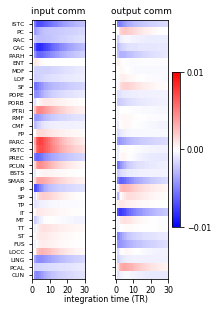

In [10]:


# ROI-based analysis

ind_occ = [37,38,39,59,61]
ind_tmp = [52,60,53,57,63]
ind_par = [58,56,55,54,34]
ind_smt = [50,51,36]
ind_frnt = [62,49,46,47,45,48,41,44,40]
ind_cing = [65,64,43,42,33,35]

ind_aff = np.array(ind_occ+ind_tmp+ind_par+ind_smt+ind_frnt+ind_cing,dtype=np.int)
ind_aff = N-1 - ind_aff


comm_tmp = comm[:,2:,:,:,:].mean(axis=(0,1)) - comm[:,:2,:,:,:].mean(axis=(0,1))
ROI_labels_sym = np.array(ROI_labels[:int(N/2)],dtype=np.str)
for i in range(int(N/2)):
    ROI_labels_sym[i] = str(ROI_labels_sym[i])[1:]
ROI_labels_sym = ROI_labels_sym[ind_aff]


pp.figure(figsize=[3,4.5])
pp.axes([0.13,0.1,0.3,0.8])
comm_sym_tmp = comm_tmp.sum(2)[:,:int(N/2)] + comm_tmp.sum(2)[:,int(N/2):][:,::-1]
pp.imshow(comm_sym_tmp[:,ind_aff].T,origin='lower',interpolation='nearest',vmin=-0.01,vmax=0.01,aspect=4.5,cmap='bwr')
iT = 4
for i in range(int(N/2)):
    comm_R = comm[:,:2,iT,:,ind_aff[i]].sum(2).reshape(-1) + comm[:,:2,iT,:,N-1-ind_aff[i]].sum(2).reshape(-1)
    comm_M = comm[:,2:,iT,:,ind_aff[i]].sum(2).reshape(-1) + comm[:,2:,iT,:,N-1-ind_aff[i]].sum(2).reshape(-1)
#    if stt.mannwhitneyu(flow_R,flow_M)[1]<0.01:
#        pp.plot(28,i,'x',ms=4,c='k')
pp.xticks([0,10,20,30],fontsize=8)
pp.yticks(range(int(N/2)),ROI_labels_sym,fontsize=6)
pp.axis(xmax=30)
#pp.xlabel('integration time (TR)',fontsize=8)
#pp.ylabel('ROI label',fontsize=8)
pp.title('input comm',fontsize=9)
pp.axes([0.51,0.1,0.35,0.8])
comm_sym_tmp = comm_tmp.sum(1)[:,:int(N/2)] + comm_tmp.sum(1)[:,int(N/2):][:,::-1]
pp.imshow(comm_sym_tmp[:,ind_aff].T,origin='lower',interpolation='nearest',vmin=-0.01,vmax=0.01,aspect=4.5,cmap='bwr')
iT = 4
for i in range(int(N/2)):
    comm_R = comm[:,:2,iT,:,ind_aff[i]].sum(2).reshape(-1) + comm[:,:2,iT,:,N-1-ind_aff[i]].sum(2).reshape(-1)
    comm_M = comm[:,2:,iT,:,ind_aff[i]].sum(2).reshape(-1) + comm[:,2:,iT,:,N-1-ind_aff[i]].sum(2).reshape(-1)
#    if stt.mannwhitneyu(flow_R,flow_M)[1]<0.01:
#        pp.plot(28,i,'x',ms=4,c='k')
pp.xticks([0,10,20,30],fontsize=8)
pp.yticks(range(int(N/2)),[],fontsize=8)
pp.axis(xmax=30)
pp.text(-5.5,-3.4,'integration time (TR)',fontsize=8,ha='center')
cb = pp.colorbar(shrink=0.6,ticks=[-0.01,0,0.01])
cb.ax.tick_params(labelsize=8)
pp.title('output comm',fontsize=9)


pp.show()

